# Phase Design

In this notebook, we will illustrate the problem of inverse design of a phase mask: we will choose the example from [Wong et al, 2021](https://ui.adsabs.harvard.edu/abs/2021JOSAB..38.2465W/abstract), designing a diffractive pupil phase mask for the Toliman telescope. 

In order to get high precision centroids, we need to maximize the gradient energy of the pupil; in order to satisfy fabrication constraints, we need a binary mask with phases only in {0, π}. 

In [31]:
import jax
from jax.config import config
import jax.numpy as np
from jax import vmap, jit
config.update("jax_enable_x64", True)

import numpy as onp
import matplotlib.pyplot as plt

from tqdm import tqdm

plt.rcParams['image.cmap'] = 'hot'
plt.rcParams["text.usetex"] = 'true'
plt.rcParams['figure.dpi'] = 120

We will first generate an orthonormal basis for the pupil phases, and then threshold this to {0, 1} while preserving soft edges using the Continuous Latent Image Mask Binarization (CLIMB) algorithm from the Wong et al paper.

In [3]:
from sklearn.decomposition import PCA

Generate the support of the pupil:

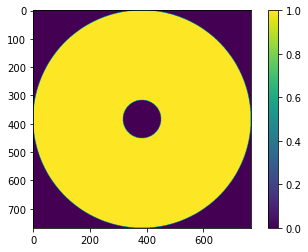

In [5]:
wf_npix = 256
oversample = 3
nslice = 3

npix = wf_npix * oversample
c = (npix - 1) / 2.
xs = (np.arange(npix, dtype=np.float64) - c) / c
XX, YY = np.meshgrid(xs, xs)
RR = np.sqrt(XX ** 2 + YY ** 2)
PHI = np.arctan2(YY, XX)

mask = np.logical_and(RR <= 1, RR >= 0.175).astype(float)
plt.imshow(mask)
plt.colorbar()
plt.show()

Generate basis vectors however you like - in this case we are using logarithmic radial harmonics and sines and cosines in θ., but you can do whatever you like here. This code is not important; just generate your favourite not-necessarily-orthonormal basis, and we will use PCA to orthonormalize it later on.

In [7]:
# a = 20
# b = 8
# ith = 40

a = 10
b = 8
ith = 20

As = np.arange(-a, a+1)
Bs = 3 * np.arange(0, b+1)
Cs = np.array([-np.pi/2, np.pi/2])
Is = np.arange(-ith, ith+1)

LRHF_fn = lambda A, B, C, RR, PHI: np.cos(A*np.log(RR + 1e-12) + B*PHI + C)
sine_fn = lambda i, RR: np.sin(i * np.pi * RR)
cose_fn = lambda i, RR: np.cos(i * np.pi * RR)

gen_LRHF_basis = vmap(vmap(vmap(LRHF_fn, (None, 0, None, None, None)), (0, None, None, None, None)), (None, None, 0, None, None))
gen_sine_basis = vmap(sine_fn, in_axes=(0, None))
gen_cose_basis = vmap(cose_fn, in_axes=(0, None))

LRHF_basis = gen_LRHF_basis(As, Bs, Cs, RR, PHI).reshape([len(As)*len(Bs)*len(Cs), npix, npix])
sine_basis = gen_sine_basis(Is, RR)
cose_basis = gen_cose_basis(Is, RR)

LRHF_flat = LRHF_basis.reshape([len(As)*len(Bs)*len(Cs), npix*npix])
sine_flat = sine_basis.reshape([len(sine_basis), npix*npix])
cose_flat = cose_basis.reshape([len(cose_basis), npix*npix])

full_basis = np.concatenate([
    LRHF_flat,
    sine_flat,
    cose_flat
])

Orthonormalize with PCA - could also use Gram-Schmidt if you prefer.

In [8]:
%%time
pca = PCA().fit(full_basis)

CPU times: user 2min 3s, sys: 7.02 s, total: 2min 10s
Wall time: 23.9 s


Show the nice basis vectors:

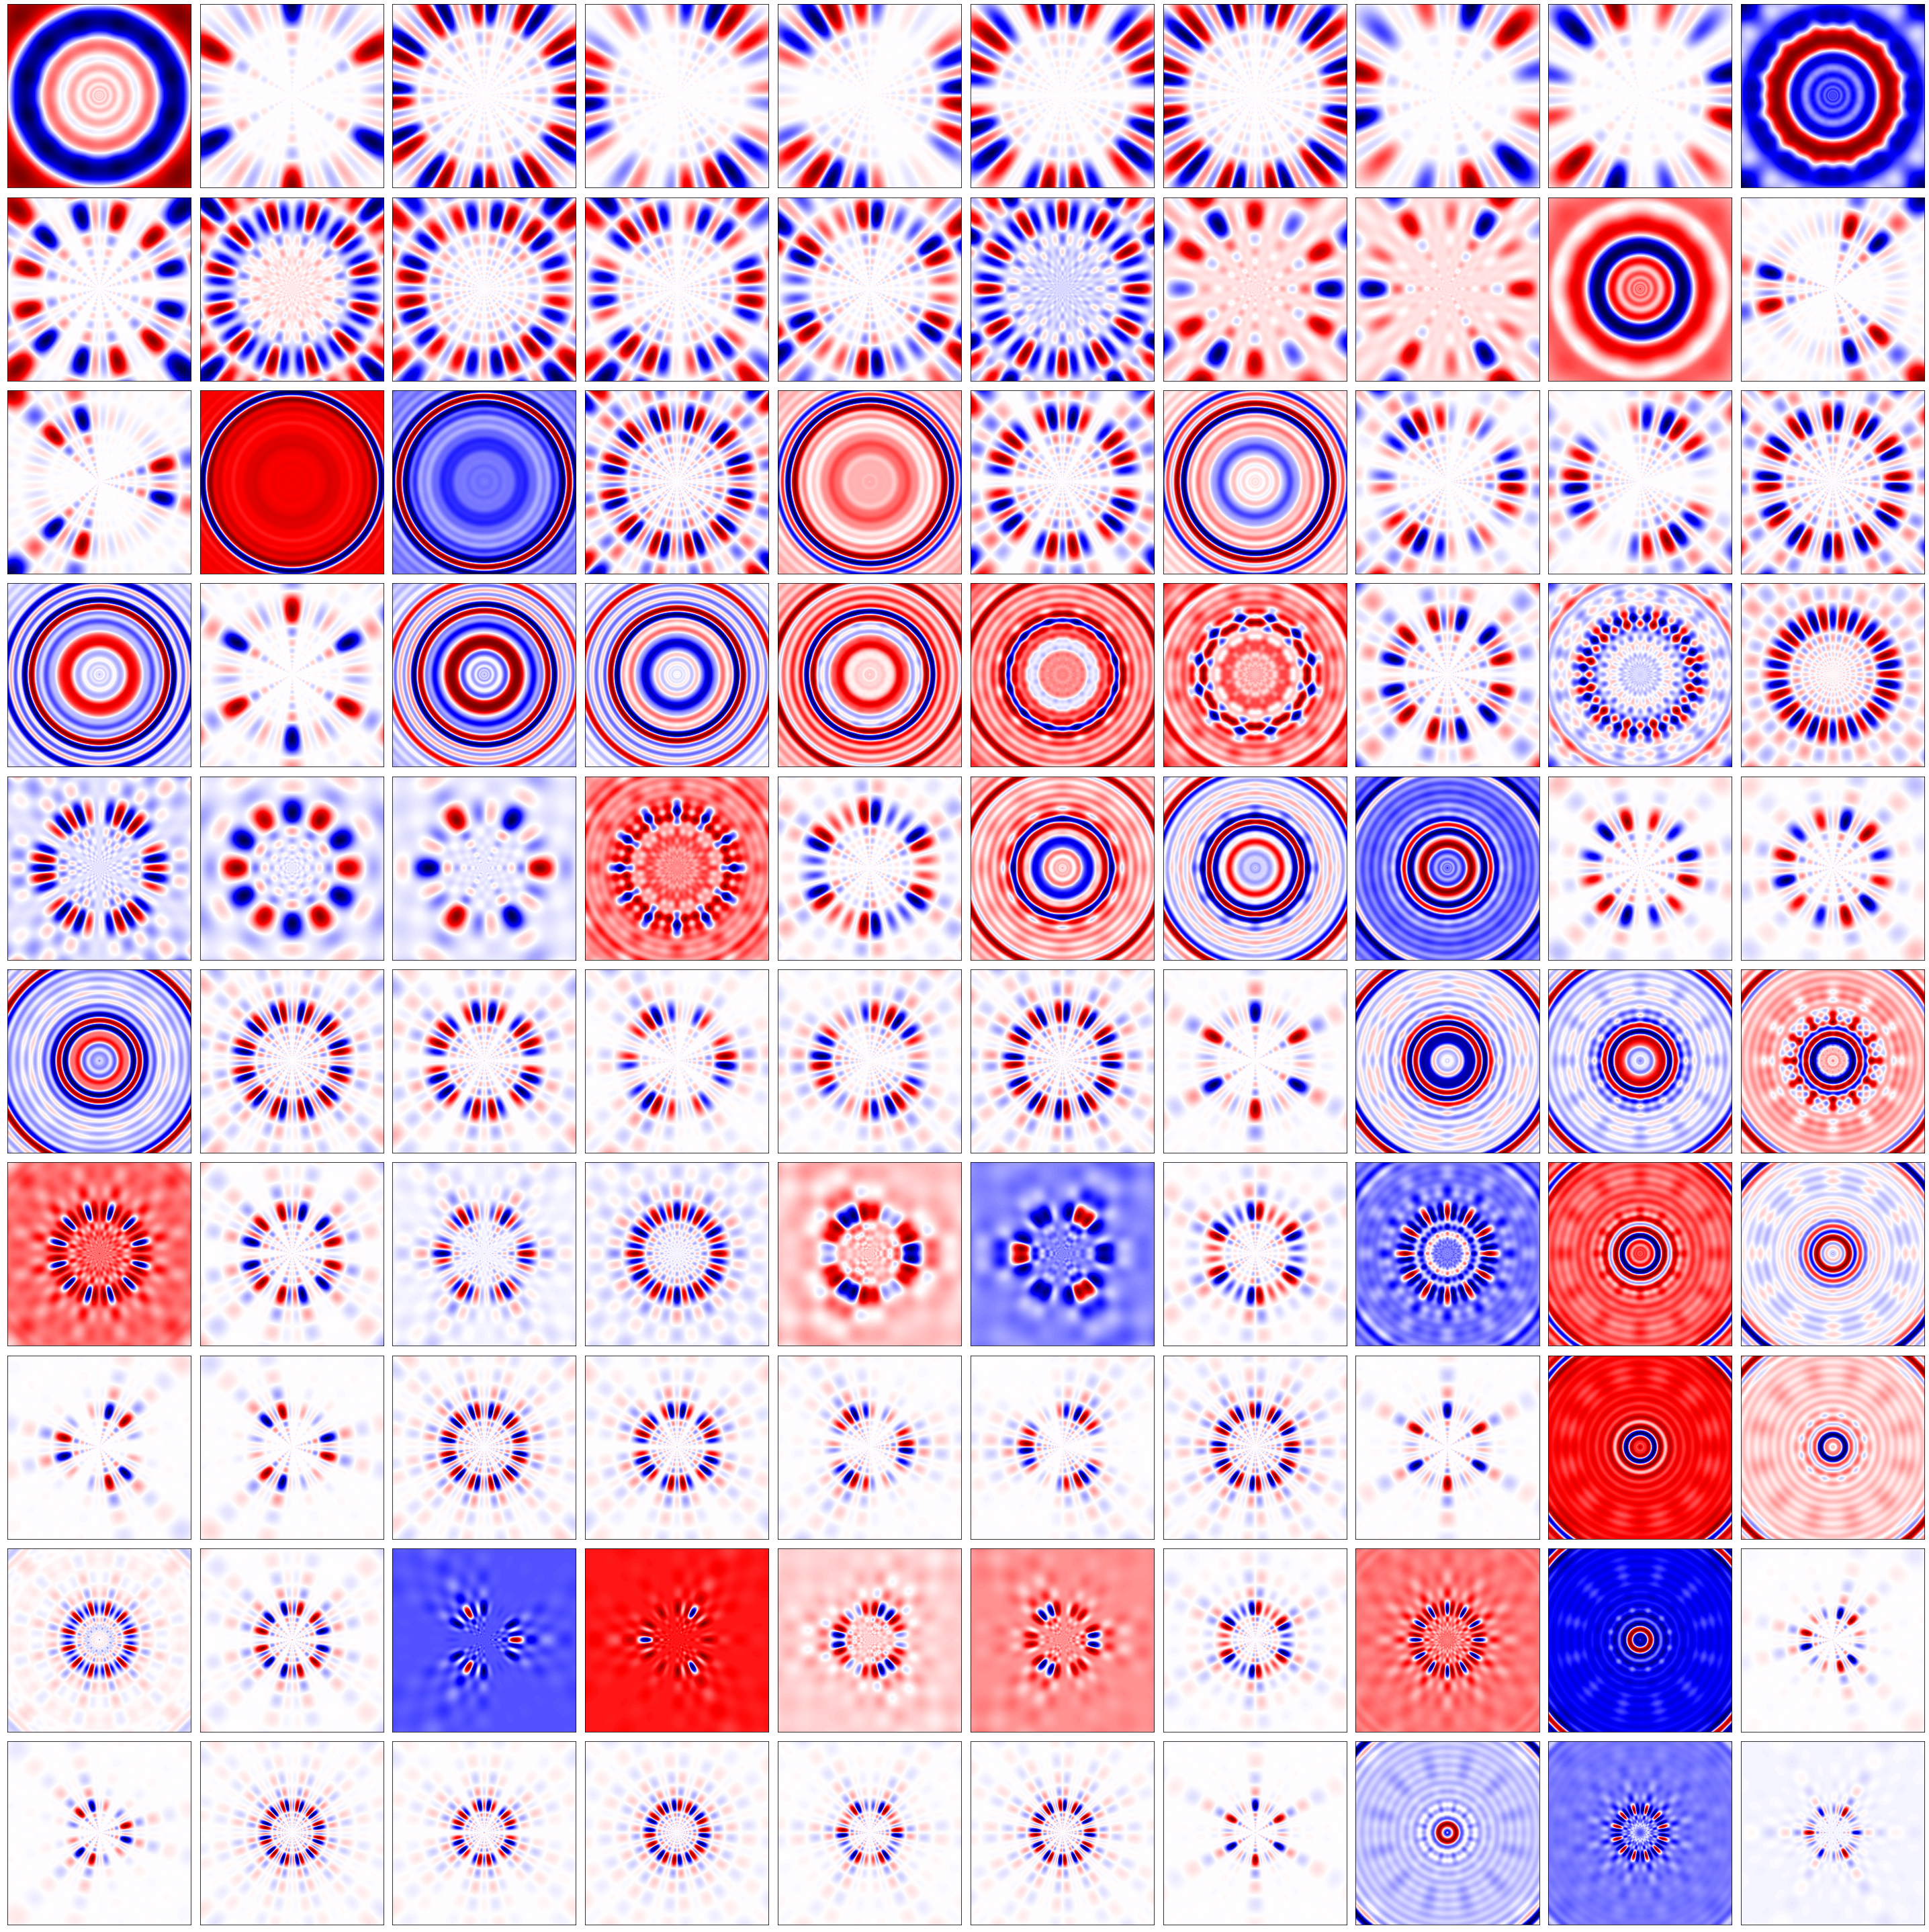

In [18]:
mean = pca.mean_.reshape([npix, npix])
components = pca.components_.reshape([len(full_basis), npix, npix])
basis = np.copy(components)#np.append(np.array([mean]), components, axis=0)
nfigs = 100

ncols = 10
nrows = 1 + nfigs//ncols

plt.figure(figsize=(4*ncols, 4*nrows))
# for i in range(len(components)):
for i in range(nfigs):
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(basis[i], cmap='seismic')
    plt.xticks([])
    plt.yticks([])
    # plt.colorbar()
plt.tight_layout()
plt.show()

### Optimizing the Pupil

First, we will import some more functions from `dLux`:

In [26]:
import equinox as eqx # object-oriented jax
import optax # optimization
import functools as ft # used for equinox filtering

import dLux as dl

from dLux.utils.models import toliman_layers # pre-built Toliman pupils
from dLux.utils.plotting import plot_batch
from dLux.utils.helpers import get_ppf # pupil scaling

Initialize a wavelength grid and decide on the mode coordinate grid scaling relative to the pupil:

In [27]:
wavels = 1e-9 * np.linspace(595, 695, 3) # wavelengths always in m

# rescale 
ppf = get_ppf(wavels)
min_fringe = 1
max_fringe = 10

rmin = min_fringe/ppf
rmax = max_fringe/ppf
print(rmin, rmax)

5.239384615384616 52.39384615384616


In [43]:
nseeds = 4
osyses = []
for i in range(nseeds):
    onp.random.seed(i)
    coeffs = onp.random.randn(0, 100, len(basis))

    layers = toliman_layers([dl.ApplyBasisCLIMB(basis, coeffs, np.mean(wavels))])    
    osyses.append(dl.OpticalSystem(layers, 
                                wavels=wavels,
                                detector_layers=[dl.ApplyJitter(1)]))
    
plot_batch(osyses, rmin=rmin, rmax=rmax, rmask=True)

TypeError: dot_general requires contracting dimensions to have the same shape, got (460,) and (100,).

<Figure size 1440x720 with 0 Axes>

In [42]:
def toliman_layers(extra_layers=[],
                   in_focus = True,
                   wf_npix = 256, 
                   det_npix = 256,
                   aperture = 0.125,
                   m2 = 0.02,
                   fl = 1.32,
                   fl_shift = 0.,
                   osamp = 5, 
                   det_pixsize = 6.5e-6
                   ):
    """
    Returns Toliman layers
    """
    
    det_pixsize /= osamp
        
    layers = [
        dl.CreateWavefront(wf_npix, aperture),
        dl.TiltWavefront(),
        dl.CircularAperture(wf_npix, rmin=m2/aperture, eps=1e-7),
        dl.NormaliseWavefront()]
    [layers.append(layer) for layer in extra_layers]
    if in_focus:
        layers.append(dl.AngularMFT(det_npix, fl, det_pixsize))
    else:
        layers.append(dl.FresnelProp(det_npix, fl, fl_shift, det_pixsize))
    
    return layers

In [41]:
osyses[0]()

TypeError: dot_general requires contracting dimensions to have the same shape, got (460,) and (100,).